In [1]:
import shap
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from tqdm import tqdm


sns.set_style("ticks", {
    "axes.grid": False,          # 去除网格
    "axes.edgecolor": "black",   # 边框颜色
    "xtick.color": "black",      # x轴刻度颜色
    "ytick.color": "black"       # y轴刻度颜色
})
import warnings
warnings.filterwarnings("ignore")

In [2]:
categorical_cols = ['gender',  
                    'hypertension', 'diabetes', 'heart_failure', 'mi', 
                    'stroke', 'sepsis', 'aki', 'ckd', 
                    'hyperlipidemia', 'peripheral_vascular_disease', 
                    'arterial_embolization', 'crrt_used', 
                    'vasoactive_used', 
                    'tibc_quantile_group', 'ferritin_quantile_group','iron_quantile_group'
                    ]


In [14]:
numeric_cols = ['age','red_blood_cells', 'hemoglobin', 
                'rdw', 'hematocrit', 'neutrophils',
                  'lymphocytes', 'platelets', 'alt', 'ast', 
                  'total_bilirubin', 'albumin', 'bun', 'creatinine', 
                  'glucose', 'sodium', 'chloride', 'free_calcium', 
                  'total_calcium', 'pao2', 'pco2', 'ph', 'lactate', 
                  'anion_gap', 'inr', 'pt', 'ptt', 
                  'heart_rate', 'resp_rate', 'temperature', 
                  'sbp', 'dbp', 'mbp', 'spo2', 'weight_admit',
                  # 'sofa_score', 'charlson_index'
                  # 'ferritin', 'tibc', 'iron'
                  ]

cols = categorical_cols + numeric_cols

In [5]:
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 63,
    'max_depth': -1,  # -1表示无限制
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'n_jobs': -1,
    'random_state': 42,
    'verbose': -1
}

In [15]:
from tabpfn import TabPFNClassifier
df = pd.read_csv('final_imputed_with_sofa_firsticu.csv')
X = df[cols]
y = df['survival_30']
# 识别特征类型
# 创建预处理步骤
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough', categorical_cols)
    ])
# 4. 创建带预处理的LassoCV管道
lasso_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', LassoCV(cv=5, random_state=42))
])

# 5. 拟合Lasso模型
lasso_pipe.fit(X, y)

# 6. 获取Lasso系数
lasso_model = lasso_pipe.named_steps['lasso']
feature_names = numeric_cols + categorical_cols
coef = pd.Series(lasso_model.coef_, index=feature_names)

# 7. 选择重要特征（系数不为零）
selected_features = coef[coef != 0].index.tolist()
# selected_features = ["sofa_score"]



print(f"Selected {len(selected_features)} features:")
print(selected_features)

# 8. 筛选特征后的数据
X_selected = X[selected_features]

# 更新特征类型列表（仅保留选中的特征）
selected_num = [col for col in numeric_cols if col in selected_features]
selected_cat = [col for col in categorical_cols if col in selected_features]



# 9. 创建新的预处理器（仅处理选中的特征）
final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), selected_num),
        ('cat', 'passthrough', selected_cat)
    ])



# 10. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

# 11. 创建并训练随机森林管道
clf_pipe = Pipeline([
    ('preprocessor', final_preprocessor),
    ('classifier', lgb.LGBMClassifier(**lgb_params))
])



Selected 24 features:
['age', 'hemoglobin', 'neutrophils', 'lymphocytes', 'platelets', 'ast', 'total_bilirubin', 'albumin', 'bun', 'glucose', 'sodium', 'chloride', 'pco2', 'ph', 'lactate', 'anion_gap', 'pt', 'heart_rate', 'resp_rate', 'mbp', 'spo2', 'weight_admit', 'vasoactive_used', 'ferritin_quantile_group']


In [16]:
clf_pipe = Pipeline([
    ('preprocessor', final_preprocessor),
    ('classifier', TabPFNClassifier(balance_probabilities=False))
])

clf_pipe.fit(X_train, y_train)

# 12. 评估模型
y_pred = clf_pipe.predict(X_test)
y_prob = clf_pipe.predict_proba(X_test)[:, 1]

print("\nModel Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Evaluation:
Accuracy: 0.8009
AUC-ROC: 0.8056

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.42      0.53        59
           1       0.82      0.93      0.87       167

    accuracy                           0.80       226
   macro avg       0.76      0.68      0.70       226
weighted avg       0.79      0.80      0.78       226



In [17]:
models = [


    # 模型1: LightGBM
    ("LightGBM", Pipeline([
        ('preprocessor', final_preprocessor),
        ('classifier', lgb.LGBMClassifier(**lgb_params, class_weight='balanced'))
    ]), 1000),
    
    # 模型2: 随机森林
    ("Random Forest", Pipeline([
        ('preprocessor', final_preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
    ]), 500),
    
    # 模型3: 逻辑回归
    ("Logistic Regression", Pipeline([
        ('preprocessor', final_preprocessor),
        ('classifier', LogisticRegression(random_state=42, max_iter=1000,class_weight='balanced'))
    ]), 500),
    
    # 模型4: XGBoost
    ("XGBoost", Pipeline([
        ('preprocessor', final_preprocessor),
        ('classifier', XGBClassifier(random_state=42, n_estimators=100,class_weight='balanced'))
    ]), 500),
    
    # 模型5: 决策树
    ("Decision Tree", Pipeline([
        ('preprocessor', final_preprocessor),
        ('classifier', DecisionTreeClassifier(random_state=42, max_depth=5,class_weight='balanced'))
    ]), 500),
    
    # 模型6: MLP (多层感知机)
    ("MLP", Pipeline([
        ('preprocessor', final_preprocessor),
        ('classifier', MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, 
                                   max_iter=1000, early_stopping=True))
    ]), 500),
    
    # 模型7: GBDT (梯度提升树)
    ("GBDT", Pipeline([
        ('preprocessor', final_preprocessor),
        ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ]), 500),
    
    # 模型8: AdaBoost
    ("AdaBoost", Pipeline([
        ('preprocessor', final_preprocessor),
        ('classifier', AdaBoostClassifier(n_estimators=100, random_state=42))
    ]), 500),
    ("TabPFN", Pipeline([
        ('preprocessor', final_preprocessor),
        ('classifier', TabPFNClassifier())
    ]), 500),

]


In [18]:
from sklearn.metrics import confusion_matrix, precision_score, f1_score
def compare_models_simple(models, X_train, X_test, y_train, y_test):
    """简化版的模型比较"""
    
    results = []
    
    for model_name, model, n_samples in models:
        print(f"训练 {model_name}...")
        
        try:

            model.fit(X_train, y_train)

            
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]
            
            cm = confusion_matrix(y_test, y_pred)
            tn, fp, fn, tp = cm.ravel()
            
            results.append({
                'Model': model_name,
                'Accuracy': accuracy_score(y_test, y_pred),
                'Sensitivity': tp / (tp + fn),
                'Specificity': tn / (tn + fp),
                'Precision': precision_score(y_test, y_pred), #PPV
                'NPV': tn / (tn + fn),
                'F1_score': f1_score(y_test, y_pred),
                'AUC_ROC': roc_auc_score(y_test, y_prob),
            })
            
        except Exception as e:
            print(f"{model_name} 失败: {e}")
            continue
    
    # 创建DataFrame并排序
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('AUC_ROC', ascending=False)
    
    # 导出结果
    results_df.to_csv('model_comparison.csv', index=False, encoding='utf-8-sig')
    
    return results_df

#
results_df = compare_models_simple(models, X_train, X_test, y_train, y_test)

训练 LightGBM...
训练 Random Forest...
训练 Logistic Regression...
训练 XGBoost...
训练 Decision Tree...
训练 MLP...
训练 GBDT...
训练 AdaBoost...
训练 TabPFN...


In [19]:
from sklearn.model_selection import StratifiedKFold

def cross_validate_roc(model_name: str, model_pipe: Pipeline, X_train, y_train, cv=5, random_state=42):
    """
    对模型进行交叉验证，计算ROC曲线和AUC值（带95%置信区间）
    """
    # 创建分层K折交叉验证
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    
    # 存储每个fold的结果
    tprs = []  # 存储每个fold的TPR
    aucs = []  # 存储每个fold的AUC
    mean_fpr = np.linspace(0, 1, 100)  # 统一的FPR网格
    
    # 存储所有fold的预测概率和真实标签（用于计算整体AUC）
    all_y_true = []
    all_y_proba = []
    
    print(f"正在对 {model_name} 进行 {cv}折交叉验证...")
    
    # 进行交叉验证
    for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X_train, y_train), 
                                                      total=cv, 
                                                      desc=f"CV {model_name}")):
        # 划分训练集和验证集
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # 训练模型
        model_pipe.fit(X_fold_train, y_fold_train)
        
        # 预测概率
        y_proba = model_pipe.predict_proba(X_fold_val)[:, 1]
        
        # 计算ROC曲线
        fpr, tpr, _ = roc_curve(y_fold_val, y_proba)
        
        # 插值到统一的FPR网格
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0  # 确保从(0,0)开始
        tprs.append(tpr_interp)
        
        # 计算AUC
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)
        
        # 保存预测结果
        all_y_true.extend(y_fold_val.values)
        all_y_proba.extend(y_proba)
    
    # 计算均值和置信区间
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0  # 确保以(1,1)结束
    
    # 计算TPR的标准差和置信区间
    std_tpr = np.std(tprs, axis=0)
    tpr_upper = np.minimum(mean_tpr + 1.96 * std_tpr, 1)  # 95%置信区间上界
    tpr_lower = np.maximum(mean_tpr - 1.96 * std_tpr, 0)  # 95%置信区间下界
    
    # 计算AUC的统计量
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    auc_ci_lower = np.percentile(aucs, 2.5)
    auc_ci_upper = np.percentile(aucs, 97.5)
    
    # 计算整体AUC（使用所有fold的预测结果）
    overall_auc = roc_auc_score(all_y_true, all_y_proba)
    
    return {
        'model_name': model_name,
        'mean_fpr': mean_fpr,
        'mean_tpr': mean_tpr,
        'tpr_lower': tpr_lower,
        'tpr_upper': tpr_upper,
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'auc_ci_lower': auc_ci_lower,
        'auc_ci_upper': auc_ci_upper,
        'overall_auc': overall_auc,
        'fold_aucs': aucs
    }



# 执行交叉验证评估所有模型
cv_results = []



score_preprocessor = StandardScaler()

score_pipe = Pipeline([
    ('preprocessor', score_preprocessor),
    ('classifier',LogisticRegression())
])

X_sofa_train, X_sofa_test, y_train, y_test = train_test_split(
    df["sofa_score"].to_frame(), y, test_size=0.2, random_state=42, stratify=y
)

result = cross_validate_roc("SOFA", score_pipe, X_sofa_train, y_train, cv=5, random_state=42)
cv_results.append(result)
# X_charlson_index_train, X_charlson_index_test, y

X_charlson_train, X_charlson_test, y_train, y_test = train_test_split(
    df["charlson_index"].to_frame(), y, test_size=0.2, random_state=42, stratify=y
)
result = cross_validate_roc("charlson", score_pipe, X_charlson_train, y_train, cv=5, random_state=42)
cv_results.append(result)


for model_name, model_pipe, _ in models:
    result = cross_validate_roc(model_name, model_pipe, X_train, y_train, cv=5, random_state=42)
    cv_results.append(result)
    print(f"{model_name} 交叉验证完成")
    print(f"  平均AUC: {result['mean_auc']:.4f} ± {result['std_auc']:.4f}")
    print(f"  95% CI: [{result['auc_ci_lower']:.4f}, {result['auc_ci_upper']:.4f}]")
    print(f"  整体AUC: {result['overall_auc']:.4f}\n")




正在对 SOFA 进行 5折交叉验证...


CV SOFA: 100%|██████████| 5/5 [00:00<00:00, 186.40it/s]


正在对 charlson 进行 5折交叉验证...


CV charlson: 100%|██████████| 5/5 [00:00<00:00, 197.63it/s]


正在对 LightGBM 进行 5折交叉验证...


CV LightGBM: 100%|██████████| 5/5 [00:00<00:00, 19.16it/s]


LightGBM 交叉验证完成
  平均AUC: 0.7434 ± 0.0417
  95% CI: [0.6772, 0.7880]
  整体AUC: 0.7406

正在对 Random Forest 进行 5折交叉验证...


CV Random Forest: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]


Random Forest 交叉验证完成
  平均AUC: 0.7632 ± 0.0333
  95% CI: [0.7308, 0.8180]
  整体AUC: 0.7623

正在对 Logistic Regression 进行 5折交叉验证...


CV Logistic Regression: 100%|██████████| 5/5 [00:00<00:00, 87.23it/s]


Logistic Regression 交叉验证完成
  平均AUC: 0.7515 ± 0.0321
  95% CI: [0.6974, 0.7827]
  整体AUC: 0.7499

正在对 XGBoost 进行 5折交叉验证...


CV XGBoost: 100%|██████████| 5/5 [00:00<00:00, 16.98it/s]


XGBoost 交叉验证完成
  平均AUC: 0.7306 ± 0.0476
  95% CI: [0.6615, 0.7945]
  整体AUC: 0.7300

正在对 Decision Tree 进行 5折交叉验证...


CV Decision Tree: 100%|██████████| 5/5 [00:00<00:00, 72.63it/s]


Decision Tree 交叉验证完成
  平均AUC: 0.6229 ± 0.0542
  95% CI: [0.5565, 0.7043]
  整体AUC: 0.6253

正在对 MLP 进行 5折交叉验证...


CV MLP: 100%|██████████| 5/5 [00:00<00:00, 14.87it/s]


MLP 交叉验证完成
  平均AUC: 0.7242 ± 0.0353
  95% CI: [0.6831, 0.7694]
  整体AUC: 0.7219

正在对 GBDT 进行 5折交叉验证...


CV GBDT: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


GBDT 交叉验证完成
  平均AUC: 0.7368 ± 0.0356
  95% CI: [0.6882, 0.7802]
  整体AUC: 0.7343

正在对 AdaBoost 进行 5折交叉验证...


CV AdaBoost: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]


AdaBoost 交叉验证完成
  平均AUC: 0.7409 ± 0.0184
  95% CI: [0.7210, 0.7656]
  整体AUC: 0.7377

正在对 TabPFN 进行 5折交叉验证...


CV TabPFN: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]

TabPFN 交叉验证完成
  平均AUC: 0.7724 ± 0.0469
  95% CI: [0.6927, 0.8092]
  整体AUC: 0.7688



In [8]:

# 绘制所有模型的ROC曲线对比图（带95%置信区间）
plt.figure(figsize=(10, 8))

# 颜色列表
colors = ['darkorange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'blue', 'magenta']

# 绘制每个模型的ROC曲线
for i, result in enumerate(cv_results):
    color = colors[i % len(colors)]
    
    # 绘制均值ROC曲线
    plt.plot(result['mean_fpr'], result['mean_tpr'], 
             color=color, lw=2.5,
             label=f"{result['model_name']} (AUC = {result['mean_auc']:.3f} [95% CI: {result['auc_ci_lower']:.3f}-{result['auc_ci_upper']:.3f}])")
    
    # # 绘制95%置信区间
    # plt.fill_between(result['mean_fpr'], result['tpr_lower'], result['tpr_upper'],
    #                  color=color, alpha=0.2)

# 绘制对角线（随机分类器）
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: Model Comparison', fontsize=14)
plt.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()

# 打印详细的AUC统计信息
print("\n" + "="*80)
print("交叉验证结果汇总 (基于X_train)")
print("="*80)
for result in cv_results:
    print(f"\n{result['model_name']}:")
    print(f"  平均AUC: {result['mean_auc']:.4f} ± {result['std_auc']:.4f}")
    print(f"  95%置信区间: [{result['auc_ci_lower']:.4f}, {result['auc_ci_upper']:.4f}]")
    print(f"  整体AUC: {result['overall_auc']:.4f}")
    print(f"  各fold AUC: {[f'{auc:.4f}' for auc in result['fold_aucs']]}")
    print(f"  变异系数: {result['std_auc']/result['mean_auc']*100:.2f}%")

# 按AUC排序显示模型性能
print("\n" + "="*80)
print("模型性能排名 (按平均AUC降序)")
print("="*80)
sorted_results = sorted(cv_results, key=lambda x: x['mean_auc'], reverse=True)
for i, result in enumerate(sorted_results, 1):
    print(f"{i}. {result['model_name']}: {result['mean_auc']:.4f} "
          f"(95% CI: [{result['auc_ci_lower']:.4f}, {result['auc_ci_upper']:.4f}])")

# 绘制AUC分布箱线图
plt.figure(figsize=(12, 8))
auc_data = [result['fold_aucs'] for result in cv_results]
model_names = [result['model_name'] for result in cv_results]

box_plot = plt.boxplot(auc_data, labels=model_names, patch_artist=True)

# 为每个箱线图设置不同颜色
colors_box = ['lightcoral', 'lightgreen', 'lightblue', 'lightpink', 
             'lightyellow', 'lightcyan', 'lightgray', 'wheat', 'lavender']

for patch, color in zip(box_plot['boxes'], colors_box):
    patch.set_facecolor(color)

plt.title('AUC Distribution Across CV Folds', fontsize=14, fontweight='bold')
plt.ylabel('AUC Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

NameError: name 'cv_results' is not defined

<Figure size 1000x800 with 0 Axes>

In [ ]:

def train_and_evaluate_model(model_name, model_pipe, X_train, X_test, y_train, y_test, 
                           n_bootstraps=1000, alpha=0.95):
    """
    训练模型并进行Bootstrap评估
    """
    # 训练模型
    model_pipe.fit(X_train, y_train)
    
    # 存储Bootstrap结果
    bootstrapped_scores = []
    fpr_grid = np.linspace(0, 1, 100)
    
    # Bootstrap评估（添加tqdm进度条）
    for i in tqdm(range(n_bootstraps), desc=f"Bootstrap {model_name}", ncols=80):
        X_val_resampled, y_val_resampled = resample(X_test, y_test, random_state=i)
        y_proba = model_pipe.predict_proba(X_val_resampled)[:, 1]
        
        fpr, tpr, _ = roc_curve(y_val_resampled, y_proba)
        tpr_interp = np.interp(fpr_grid, fpr, tpr)
        tpr_interp[0] = 0.0
        
        roc_auc = auc(fpr, tpr)
        
        bootstrapped_scores.append({
            'fpr': fpr_grid,
            'tpr': tpr_interp,
            'auc': roc_auc
        })
    
    # 计算统计量
    tpr_scores = np.array([score['tpr'] for score in bootstrapped_scores])
    auc_scores = np.array([score['auc'] for score in bootstrapped_scores])
    
    tpr_mean = np.mean(tpr_scores, axis=0)
    tpr_lower = np.percentile(tpr_scores, (1 - alpha) * 100 / 2, axis=0)
    tpr_upper = np.percentile(tpr_scores, 100 - (1 - alpha) * 100 / 2, axis=0)
    
    auc_mean = np.mean(auc_scores)
    auc_std = np.std(auc_scores)
    auc_ci_lower = np.percentile(auc_scores, 2.5)
    auc_ci_upper = np.percentile(auc_scores, 97.5)

    return {
        'model_name': model_name,
        'model_pipe': model_pipe,
        'fpr_grid': fpr_grid,
        'tpr_mean': tpr_mean,
        'tpr_lower': tpr_lower,
        'tpr_upper': tpr_upper,
        'auc_mean': auc_mean,
        'auc_std': auc_std,
        'auc_scores': auc_scores,
        'auc_ci_lower': auc_ci_lower,
        'auc_ci_upper': auc_ci_upper
    }

# 颜色列表用于区分不同模型


# 存储所有模型的结果
model_results = []

result = train_and_evaluate_model(
    'SOFA', score_pipe, X_sofa_train, X_sofa_test, y_train, y_test
)
model_results.append(result)

result = train_and_evaluate_model(
    'charlson', score_pipe, X_charlson_train, X_charlson_test, y_train, y_test
)
model_results.append(result)
# 训练和评估所有模型

# 训练所有模型
for model_name, model_pipe, n_bootstraps in models:
    print(f"正在训练 {model_name}...")
    result = train_and_evaluate_model(
        model_name, model_pipe, X_train, X_test, y_train, y_test, n_bootstraps=n_bootstraps
    )
    model_results.append(result)
    print(f"{model_name} 训练完成，AUC: {result['auc_mean']:.4f}")



In [ ]:

plt.figure(figsize=(10, 8))

# 绘制每个模型的ROC曲线
for i, result in enumerate(model_results):
    color = colors[i % len(colors)]
    
    # 绘制均值ROC曲线
    plt.plot(result['fpr_grid'], result['tpr_mean'], color=color, lw=2,
             label=f"{result['model_name']} (AUC = {result['auc_mean']:.3f} (95% CI: [{result['auc_ci_lower']:.3f}, {result['auc_ci_upper']:.3f}])")
    
    # 可选：绘制置信区间（如果模型太多可以注释掉）
    # plt.fill_between(result['fpr_grid'], result['tpr_lower'], result['tpr_upper'], 
    #                 color=color, alpha=0.1)

# 绘制对角线
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: Model Comparison', fontsize=14)
plt.legend(loc="lower right", fontsize=9)
# plt.grid(True, alpha=0.3)

# 5. 打印每个模型的AUC统计信息
print("\n=== 模型比较结果 ===")
for result in model_results:
    print(f"\n{result['model_name']}:")
    print(f"  AUC均值: {result['auc_mean']:.4f}")
    print(f"  AUC标准差: {result['auc_std']:.4f}")
    print(f"  95%置信区间: [{result['auc_ci_lower']:.4f}, {result['auc_ci_upper']:.4f}]")
    print(f"  变异系数: {result['auc_std']/result['auc_mean']*100:.2f}%")

plt.tight_layout()
plt.show()

# 6. 绘制AUC分布箱线图进行更直观的比较
plt.figure(figsize=(12, 8))
auc_data = [result['auc_scores'] for result in model_results]
model_names = [result['model_name'] for result in model_results]

box_plot = plt.boxplot(auc_data, labels=model_names, patch_artist=True)

# 为每个箱线图设置不同颜色
colors_box = ['lightcoral', 'lightgreen', 'lightblue', 'lightpink', 
             'lightyellow', 'lightcyan', 'lightgray', 'wheat']

for patch, color in zip(box_plot['boxes'], colors_box):
    patch.set_facecolor(color)

plt.title('AUC Distribution Comparison', fontsize=14)
plt.ylabel('AUC Score')
plt.xticks(rotation=45)
# plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7. 按AUC排序显示模型性能
print("\n=== 模型性能排名 (按AUC降序) ===")
sorted_results = sorted(model_results, key=lambda x: x['auc_mean'], reverse=True)
for i, result in enumerate(sorted_results, 1):
    print(f"{i}. {result['model_name']}: {result['auc_mean']:.4f} (95% CI: [{result['auc_ci_lower']:.4f}, {result['auc_ci_upper']:.4f}])")

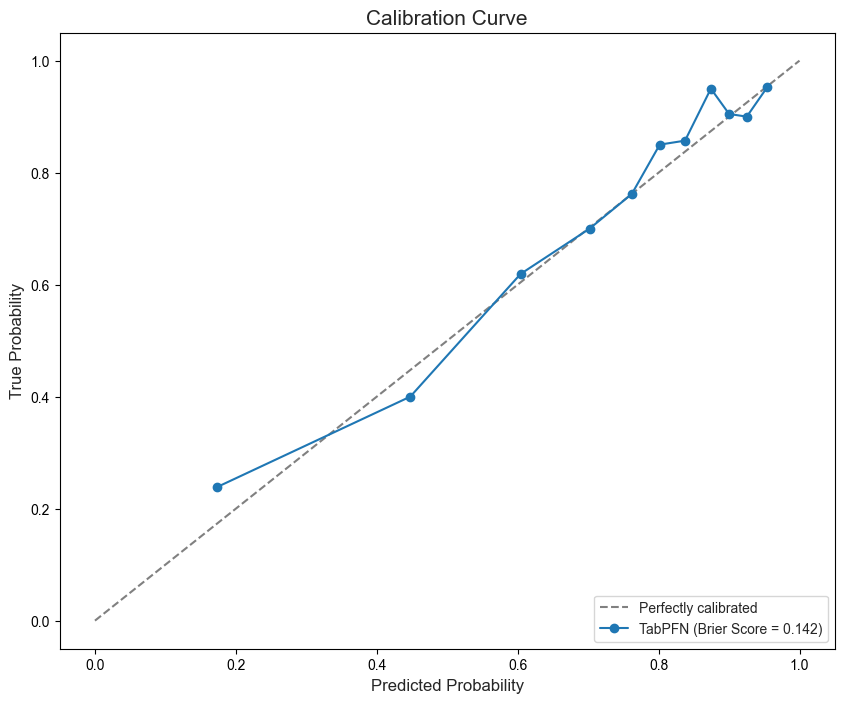

In [18]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import numpy as np

# 1. 绘制Calibration校准曲线
plt.figure(figsize=(10, 8))

# 计算校准曲线
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=11, strategy='quantile')

# 绘制完美校准线
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated', color='gray')
# 计算Brier分数
brier_score = brier_score_loss(y_test, y_prob)
# 绘制模型校准曲线
plt.plot(prob_pred, prob_true, marker='o', label=f'TabPFN (Brier Score = {brier_score:.3f})')


plt.title(f'Calibration Curve', fontsize=15)
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('True Probability', fontsize=12)
plt.legend(loc='lower right')
# plt.grid(True)
plt.show()



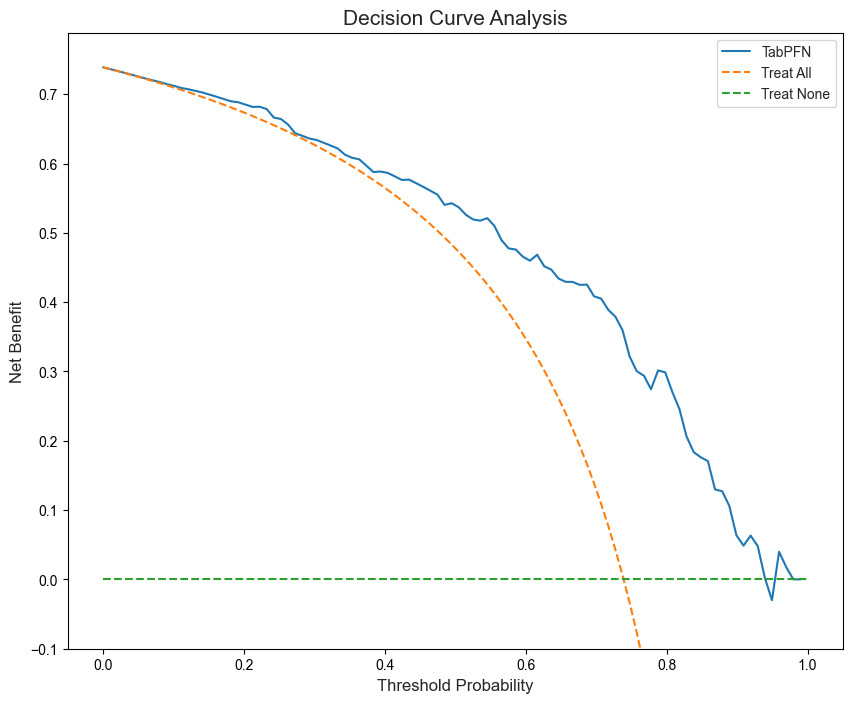

In [19]:

# 2. 绘制DCA(Decision Curve Analysis)曲线
def plot_decision_curve(y_true, y_prob, label="LightGBM"):
    # 定义阈值范围
    thresholds = np.linspace(0, 1, 100)
    
    # 计算净收益
    net_benefit = []
    n = len(y_true)
    for threshold in thresholds:
        # 预测阳性
        y_pred = (y_prob >= threshold).astype(int)
        
        # 计算真阳性和假阳性
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        
        # 计算净收益
        nb = (tp / n) - (fp / n) * (threshold / (1 - threshold))
        net_benefit.append(nb)
    
    # 计算"全部治疗"和"全部不治疗"的净收益
    prevalence = np.mean(y_true)
    all_treat = [prevalence - (1 - prevalence) * (t / (1 - t)) for t in thresholds]
    none_treat = [0 for _ in thresholds]
    
    # 绘制曲线
    plt.figure(figsize=(10, 8))
    plt.plot(thresholds, net_benefit, label=label)
    plt.plot(thresholds, all_treat, label='Treat All', linestyle='--')
    plt.plot(thresholds, none_treat, label='Treat None', linestyle='--')
    
    plt.title('Decision Curve Analysis', fontsize=15)
    plt.xlabel('Threshold Probability', fontsize=12)
    plt.ylabel('Net Benefit', fontsize=12)
    plt.legend(loc='upper right')
    # plt.grid(True)
    plt.ylim(-0.1, max(net_benefit) + 0.05)
    plt.show()

# 调用DCA函数
plot_decision_curve(y_test, y_prob, label="TabPFN")

In [ ]:
# 11. SHAP值分析准备
# 获取预处理后的特征名称
processed_features = selected_num + selected_cat

# 创建解释器需要的数据（预处理后的数据）
X_train_preprocessed = final_preprocessor.transform(X_train)
X_test_preprocessed = final_preprocessor.transform(X_test)

# 从管道中提取模型
clf_model = clf_pipe.named_steps['classifier']

# 12. 计算SHAP值 - 使用 KernelExplainer
# 方法1: KernelExplainer (更准确但较慢)
# 使用训练数据的一个子集作为背景数据
background_data = shap.sample(X_train_preprocessed, 100)  # 采样100个样本作为背景

# 定义预测函数
def model_predict(X):
    return clf_model.predict_proba(X)[:, 1]  # 返回正类的概率

explainer = shap.KernelExplainer(model_predict, background_data)

# 计算测试集的SHAP值（或训练集的子集）
# 注意：KernelExplainer比较慢,建议用少量样本
X_explain = shap.sample(X_test_preprocessed, 100)  # 解释100个测试样本
shap_values = explainer.shap_values(X_explain)

print("SHAP值计算完成!")
print(f"SHAP值形状: {shap_values.shape}")

In [ ]:
# 方法2: PermutationExplainer (更快但略微不准确)
import shap

# 使用 PermutationExplainer
explainer = shap.PermutationExplainer(model_predict, X_train_preprocessed[:100])
X_explain = X_test_preprocessed[:100]
shap_values = explainer.shap_values(X_explain)

print("SHAP值计算完成!")

In [ ]:
shap.summary_plot(shap_values, X_train_preprocessed, feature_names=processed_features, plot_type="bar")

In [ ]:
# Summary plot - 显示所有特征的重要性
shap.summary_plot(shap_values, X_explain, 
                  feature_names=feature_names, 
                  show=False)
plt.tight_layout()
plt.show()

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# 选择要解释的样本索引
sample_idx = 2

# 获取该样本的SHAP值和特征值
sample_shap_values = shap_values[sample_idx]
sample_features = X_test_preprocessed[sample_idx]

# 手动计算基准值（模型在背景数据集上的平均预测）
baseline_value = model_predict(X_train_preprocessed[:100]).mean()

print(f"手动计算的基准值: {baseline_value}")

In [ ]:
# 绘制SHAP力图
sample_shap_values_rounded = np.round(sample_shap_values, 2)
sample_features_rounded = np.round(sample_features, 2)
baseline_value_rounded = round(float(baseline_value), 2)

shap.force_plot(
    baseline_value_rounded,
    sample_shap_values_rounded,
    sample_features_rounded,
    feature_names=processed_features,
    matplotlib=True,
    show=False
)
plt.title(f'SHAP Force Plot - Index: {sample_idx}', fontsize=14)
plt.tight_layout()
plt.savefig('shap_force_plot.png', dpi=300, bbox_inches='tight')
plt.show()
